<a href="https://colab.research.google.com/github/jiya07/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/blob/main/Numerical_and_Textual_Analysis_of_Stock_Market_Prices_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Swapnil Singh

## Task 4-Numerical_and_Textual_Analysis_of_Stock_Market_Prices
Create a hybrid model for stock price/performance prediction using
numerical analysis of historical stock prices, and sentimental analysis
of news headlines

In [ ]:
from google.colab import files 
uploaded = files.upload()

In [ ]:
from google.colab import files 
uploaded = files.upload()

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TIME SERIES ANALYSIS

In [2]:
df_prices = pd.read_csv('BSESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date         Open         High          Low        Close  \
0  2001-01-02  3953.219971  4028.570068  3929.370117  4018.879883   
1  2001-01-03  3977.580078  4067.659912  3977.580078  4060.020020   
2  2001-01-04  4180.970215  4180.970215  4109.549805  4115.370117   
3  2001-01-05  4116.339844  4195.009766  4115.350098  4183.729980   
4  2001-01-08  4164.759766  4206.720215  4101.529785  4120.430176   

     Adj Close  Volume  
0  4018.879883     0.0  
1  4060.020020     0.0  
2  4115.370117     0.0  
3  4183.729980     0.0  
4  4120.430176     0.0  
34622


In [3]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 7 columns):
Date         4946 non-null datetime64[ns]
Open         4872 non-null float64
High         4872 non-null float64
Low          4872 non-null float64
Close        4872 non-null float64
Adj Close    4872 non-null float64
Volume       4872 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 270.6 KB


In [4]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

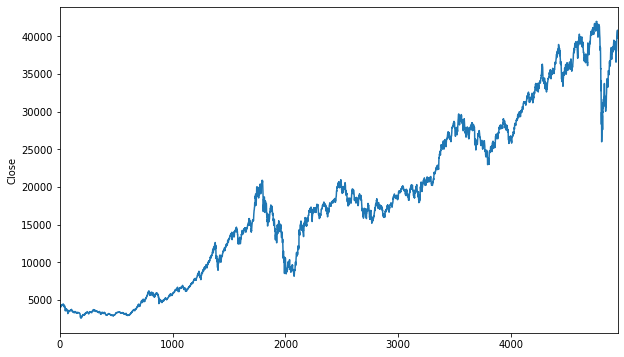

In [5]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

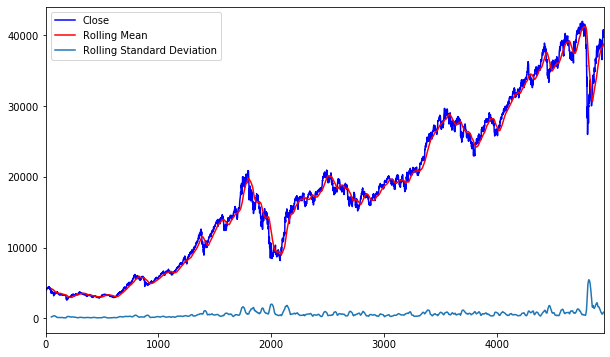

In [6]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

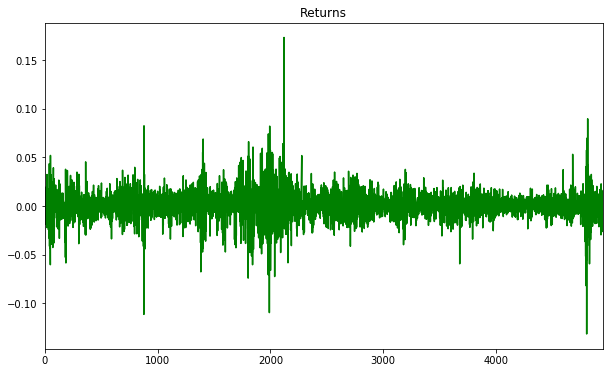

In [7]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [8]:
train = df_prices[:1000]
test = df_prices[1000:]

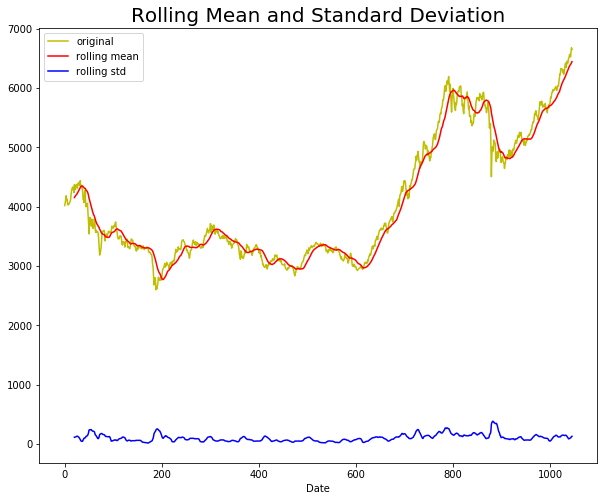

Results of dickey fuller test
ADF Test Statistic : 0.6847089129500293
p-value : 0.9895277172383614
#Lags Used : 6
Number of Observations Used : 993
Weak evidence against null hypothesis, time series is non-stationary 


In [9]:
#Stationarity test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)
 
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

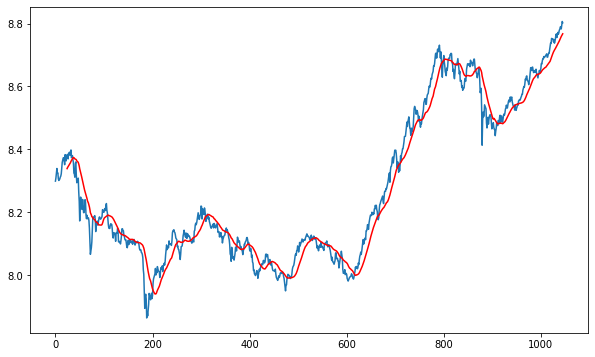

In [10]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

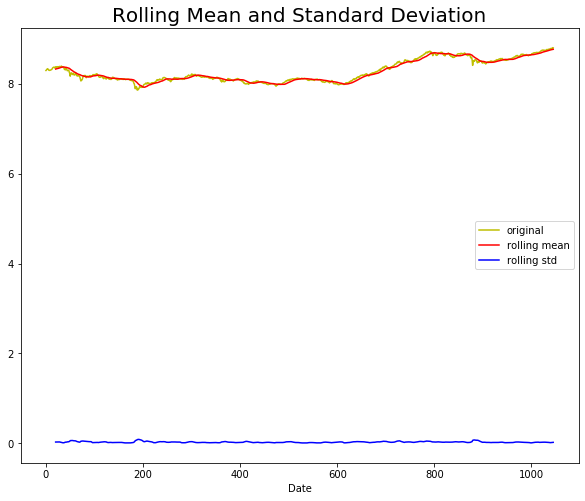

Results of dickey fuller test
ADF Test Statistic : 0.09925455869130678
p-value : 0.9660101624822954
#Lags Used : 4
Number of Observations Used : 995
Weak evidence against null hypothesis, time series is non-stationary 


In [11]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

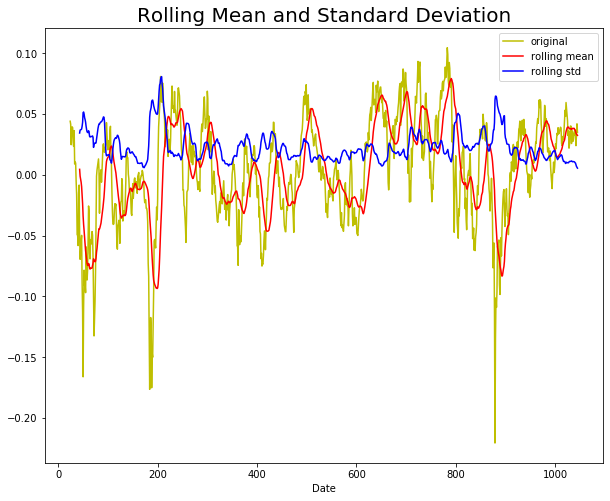

Results of dickey fuller test
ADF Test Statistic : -5.736980339921392
p-value : 6.404632148346552e-07
#Lags Used : 4
Number of Observations Used : 972
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [12]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [13]:
#conda install -c saravji pmdarima

In [14]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=-5635.045, BIC=-5605.610, Fit time=2.076 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=-5034.986, BIC=-5025.175, Fit time=0.126 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=-5213.672, BIC=-5198.954, Fit time=0.238 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=-5634.145, BIC=-5619.428, Fit time=1.083 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=-5638.216, BIC=-5613.688, Fit time=1.816 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=-5578.562, BIC=-5558.939, Fit time=0.786 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=-5607.762, BIC=-5578.328, Fit time=0.884 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=-5640.240, BIC=-5605.900, Fit time=3.889 seconds
Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=-5637.265, BIC=-5598.019, Fit time=4.655 seconds
Fit ARIMA: order=(2

Text(0, 0.5, 'Actual Stock Price')

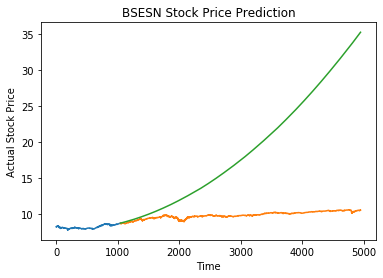

In [15]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [16]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  11.684633920681051


TEXTUAL ANALYSIS

In [17]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?
5,20010102,unknown,For bigwigs; it is destination Goa
6,20010102,unknown,Extra buses to clear tourist traffic
7,20010102,unknown,Dilute the power of transfers; says Riberio
8,20010102,unknown,Focus shifts to teaching of Hindi
9,20010102,unknown,IT will become compulsory in schools


In [18]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
Date    object
News    object
dtypes: object(2)
memory usage: 75.5+ MB


In [19]:
 #Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news=df_news.head(10000)

In [20]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
5,2001-01-06,Light combat craft takes India into club class...
6,2001-01-07,Muslim body rules out talks on Ayodhya Bajrang...
7,2001-01-08,Sangh Parivar; Babri panel up the ante Frontru...
8,2001-01-09,Financier Bharat Shah held for alleged links w...
9,2001-01-10,Fend for yourselves; Pande tells doctors Burea...


In [21]:
df_news['News']

0      win over cena satisfying but defeating underta...
1      Status quo will not be disturbed at Ayodhya; s...
2      Powerless north India gropes in the dark Think...
3      The string that pulled Stephen Hawking to Indi...
4      Light combat craft takes India into club class...
5      Light combat craft takes India into club class...
6      Muslim body rules out talks on Ayodhya Bajrang...
7      Sangh Parivar; Babri panel up the ante Frontru...
8      Financier Bharat Shah held for alleged links w...
9      Fend for yourselves; Pande tells doctors Burea...
10     shreyas gopal scores ton as karnataka stay on ...
11     Sonia takes on the Hindutva brigade Congress h...
12     Govt extends J&K ceasefire by a month Peace hi...
13     Big bath passes without a hitch Security bando...
14     President against pitch for indirect polls TRA...
15     Monster quake kills 4;000 Forces to the rescue...
16     Death; distress; destruction...and it's not ov...
17     More tremors forecast fo

In [22]:
#Cleaning headlines
c = []
ps=PorterStemmer()
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [23]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
2,2001-01-03,powerless north india grope dark think laxman ...
3,2001-01-04,string pull stephen hawk india vajpaye give bi...
4,2001-01-05,light combat craft take india club class hawk ...
5,2001-01-06,light combat craft take india club class hawk ...
6,2001-01-07,muslim bodi rule talk ayodhya bajrang dal blow...
7,2001-01-08,sangh parivar babri panel ant frontrunn key us...
8,2001-01-09,financi bharat shah held alleg link chotta sha...
9,2001-01-10,fend pand tell doctor bureaucraci undermin leg...


In [24]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [25]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
5,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
6,2001-01-07,muslim bodi rule talk ayodhya bajrang dal blow...,0.409895,-0.023993
7,2001-01-08,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142
8,2001-01-09,financi bharat shah held alleg link chotta sha...,0.453860,0.057229
9,2001-01-10,fend pand tell doctor bureaucraci undermin leg...,0.000000,0.000000


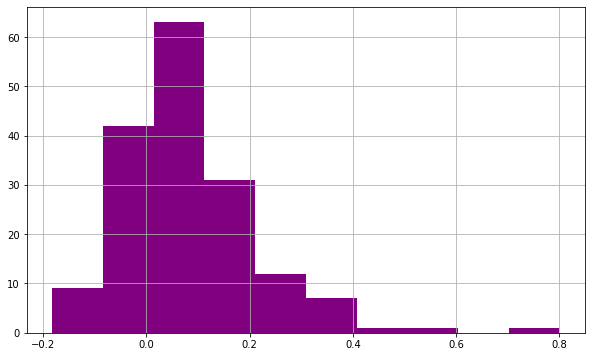

In [26]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

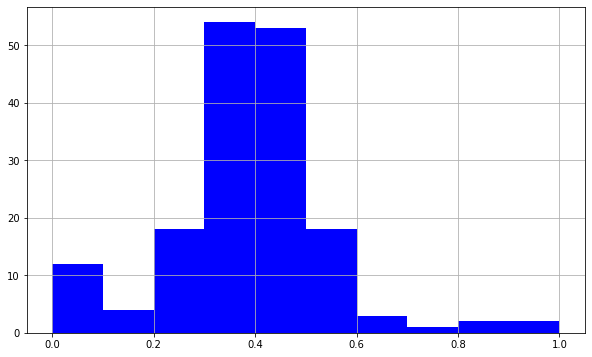

In [27]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [28]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000,0.2023,0.234,0.469,0.297
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
5,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
6,2001-01-07,muslim bodi rule talk ayodhya bajrang dal blow...,0.409895,-0.023993,-0.9937,0.164,0.788,0.049
7,2001-01-08,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
8,2001-01-09,financi bharat shah held alleg link chotta sha...,0.453860,0.057229,-0.9928,0.141,0.813,0.047
9,2001-01-10,fend pand tell doctor bureaucraci undermin leg...,0.000000,0.000000,0.0000,0.000,1.000,0.000


In [29]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
5,2001-01-09,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0,financi bharat shah held alleg link chotta sha...,0.453860,0.057229,-0.9928,0.141,0.813,0.047
6,2001-01-10,4151.580078,4155.859863,4035.439941,4047.639893,4047.639893,0.0,fend pand tell doctor bureaucraci undermin leg...,0.000000,0.000000,0.0000,0.000,1.000,0.000
7,2001-01-11,4066.129883,4077.540039,4006.540039,4027.129883,4027.129883,0.0,shreya gopal score ton karnataka stay top mumb...,0.500000,0.250000,0.2023,0.000,0.886,0.114
8,2001-01-23,4277.830078,4321.750000,4272.870117,4296.689941,4296.689941,0.0,sonia take hindutva brigad congress hope soar ...,0.238603,0.073320,0.9643,0.040,0.843,0.117
9,2001-01-24,4320.509766,4339.410156,4295.709961,4326.419922,4326.419922,0.0,govt extend j k ceasefir month peac hing human...,0.191270,0.079048,0.2263,0.083,0.830,0.087


In [30]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,4060.020020,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,4115.370117,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,4183.729980,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,4120.430176,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
5,4125.310059,0.453860,0.057229,-0.9928,0.141,0.813,0.047
6,4047.639893,0.000000,0.000000,0.0000,0.000,1.000,0.000
7,4027.129883,0.500000,0.250000,0.2023,0.000,0.886,0.114
8,4296.689941,0.238603,0.073320,0.9643,0.040,0.843,0.117
9,4326.419922,0.191270,0.079048,0.2263,0.083,0.830,0.087


In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.665840,0.298148,0.557192,0.072909,0.382263,0.699735,0.134921
1,0.698641,0.429167,0.410533,0.202397,0.403670,0.675926,0.149471
2,0.742772,0.475140,0.425345,0.969057,0.302752,0.723545,0.145503
3,0.797276,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
4,0.746807,0.486204,0.291458,0.161240,0.305810,0.756614,0.111111


In [32]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [33]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.298148,0.557192,0.072909,0.382263,0.699735,0.134921
1,0.429167,0.410533,0.202397,0.403670,0.675926,0.149471
2,0.475140,0.425345,0.969057,0.302752,0.723545,0.145503
3,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
4,0.486204,0.291458,0.161240,0.305810,0.756614,0.111111


In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(92, 6)

In [35]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
71,0.390873,0.193688,0.032764,0.470948,0.679894,0.116402
97,0.426136,0.626521,0.607746,0.440367,0.574074,0.235450
111,0.373858,0.346604,0.001517,0.425076,0.722222,0.093915
100,0.227273,0.496028,0.505461,0.000000,1.000000,0.000000
8,0.238603,0.506202,0.993023,0.122324,0.792328,0.154762
93,0.325108,0.854580,0.998382,0.232416,0.690476,0.208995
33,0.440734,0.270752,0.815098,0.211009,0.791005,0.117725
45,0.442549,0.500399,0.965568,0.385321,0.630952,0.202381
3,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
48,0.501515,0.556311,0.864698,0.437309,0.592593,0.218254


In [36]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [37]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.34890917 0.61768574 0.76173699 0.46871673 0.3484404  0.46782451
 0.36897749 0.34528224 0.24066106 0.4613129 ]
10     0.914074
74     0.299788
66     0.190549
51     0.304476
7      0.672418
78     0.387484
92     0.107557
90     0.176899
107    0.197860
62     0.321507
Name: Close, dtype: float64
0.11036450361316319


In [38]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [39]:
print(mean_squared_error(predictions, y_test))

0.10553871861552837


In [40]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [41]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.21767311 0.28727815 0.91104408 0.94029727 0.87890454 0.89175724
 0.36082184 0.84775385 0.06000542 0.97473296]
10     0.914074
74     0.299788
66     0.190549
51     0.304476
7      0.672418
78     0.387484
92     0.107557
90     0.176899
107    0.197860
62     0.321507
Name: Close, dtype: float64
0.1762078494350633


In [42]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.12259136975378587


In [44]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [45]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.1612475688317745


We observe that Xgboost model performs the best for the sentiment analysis